# Dynamic network analysis
This is a brief single-notebook tutorial for dynamic gene regulatory network analysis. For extra details, see other notebooks in the same folder.
## Configuration

In [1]:
# Configure matplotlib to enable large animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt
# Download network data from zenodo
!cd ../.. && dictys_helper repodown.sh zenodo analysis-blood.tar.xz


## Load data

In [2]:
import dictys
from dictys.net import dynamic_network

d0=dynamic_network.from_file('../../data/dynamic.h5')


## TF discovery based on 4 patterns of highly variable regulatory activity over developmental trajectory ([discovery.ipynb](discovery.ipynb))

Monocyte


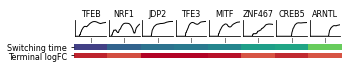

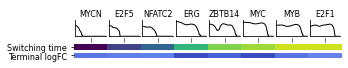

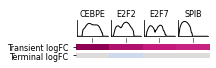

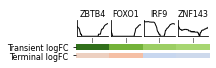

Erythroid


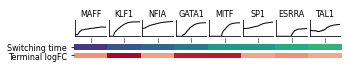

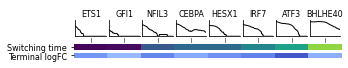

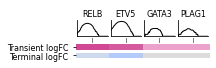

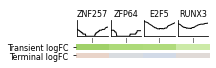

B


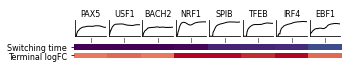

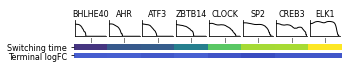

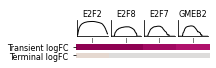

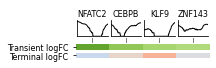

In [3]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
#See example trajectory-blood
branches={
	'Monocyte':(0,1),
	'Erythroid':(0,2),
	'B':(0,3),
}
#Value range for coloring
vrange={
	'Terminal logFC':[-9,9],
	'Transient logFC':[-3.5,3.5],
	'Switching time':[0.15,0.85],
}

for branchname in branches:
	print(branchname)
	figs=d0.draw_discover(*branches[branchname],vrange=vrange)
	plt.show()


### Colorbar

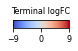

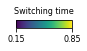

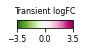

In [4]:
from operator import or_
from functools import reduce
from dictys.plot import colorbar

#Color bar font size
fs=8

colormaps=reduce(or_,[x[2] for x in figs])
for xi0 in range(len(colormaps)):
	xi=list(colormaps)[xi0]
	colormap=colormaps[xi]
	ans2=colorbar(colormap.cmap.name,colormap.norm.vmin,colormap.norm.vmax,orientation='horizontal',figsize=(1,0.15),title=xi,title_fontsize=fs)
	xticks=[colormap.norm.vmin,0,colormap.norm.vmax] if colormap.norm.vmin*colormap.norm.vmax<0 else [colormap.norm.vmin,colormap.norm.vmax]
	ans2[1].set_xticks(xticks)
	ans2[1].tick_params(axis='x',labelsize=fs)


## Animation visualization of dynamic networks
### Animation layout

Here we use the following animation panel layout. Each row for c,d,e,f has their own set of select TFs. The layout is arbitrary and you can design your own custom layout with `matplotlib`.

```
+---+       +---+
| a |       | b |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+
```

* a: Dynamic tracking of cells used for GRN inference
* b: Dynamic scatter plot for differential regulation v.s. differential expression logFCs
* c: Dynamic plot for expression level (log CPM) of select TFs as a function of pseudo-time
* d: Dynamic plot for regulatory activity (log target count) of select TFs as a function of pseudo-time
* e: Dynamic heatmap for regulation strength from select TFs to select target genes
* f: Dynamic subnetwork graph from select TF to its targets

### Branch independent parameters

In [5]:
import itertools
from os import linesep
from functools import partial
from dictys.net.layout import _fruchterman_reingold
from dictys.net import stat
from dictys.plot import panel

# Kernel smoothing distance
dist=1.5
# Number of frames (interpolated time points), use 100 or higher for finer resolution
nframe=20
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# Size of each panel
panelsize=(6,4)
# DPI for animation
dpi=200
# Bit rate for each panel, each FPS, and each dot per square inch. Increase for higher vidoe quality. Decrease for smaller file size.
bitrate=1/400
# Smoothing parameters for subnetwork layout coordinates. Should be left unchanged
weightfunc_linear=['linear',[],dict()]


### Erythroid branch
#### Branch dependent customizations

In [6]:
branchname='Erythroid'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['HLF'],
	['GATA1'],
]
# Select TFs for each row's other plots
tfs_ann=[
	['MYCN', 'HLF'],
	['GATA1', 'KLF1', 'HLTF', 'TAL1'],
]
# Select genes to annotate as targets in all rows
target_ann=['CD34', 'GYPC', 'PRIM1', 'TRIM58', 'XPO7', 'YOD1', 'BTRC','FBXO9', 'PRPS1', 'MTMR3', 'MTMR12','MAZ','SLC2A1','PPOX','ADD2','ALAD','CDC20','NUSAP1','E2F2']


#### Branch independent lines

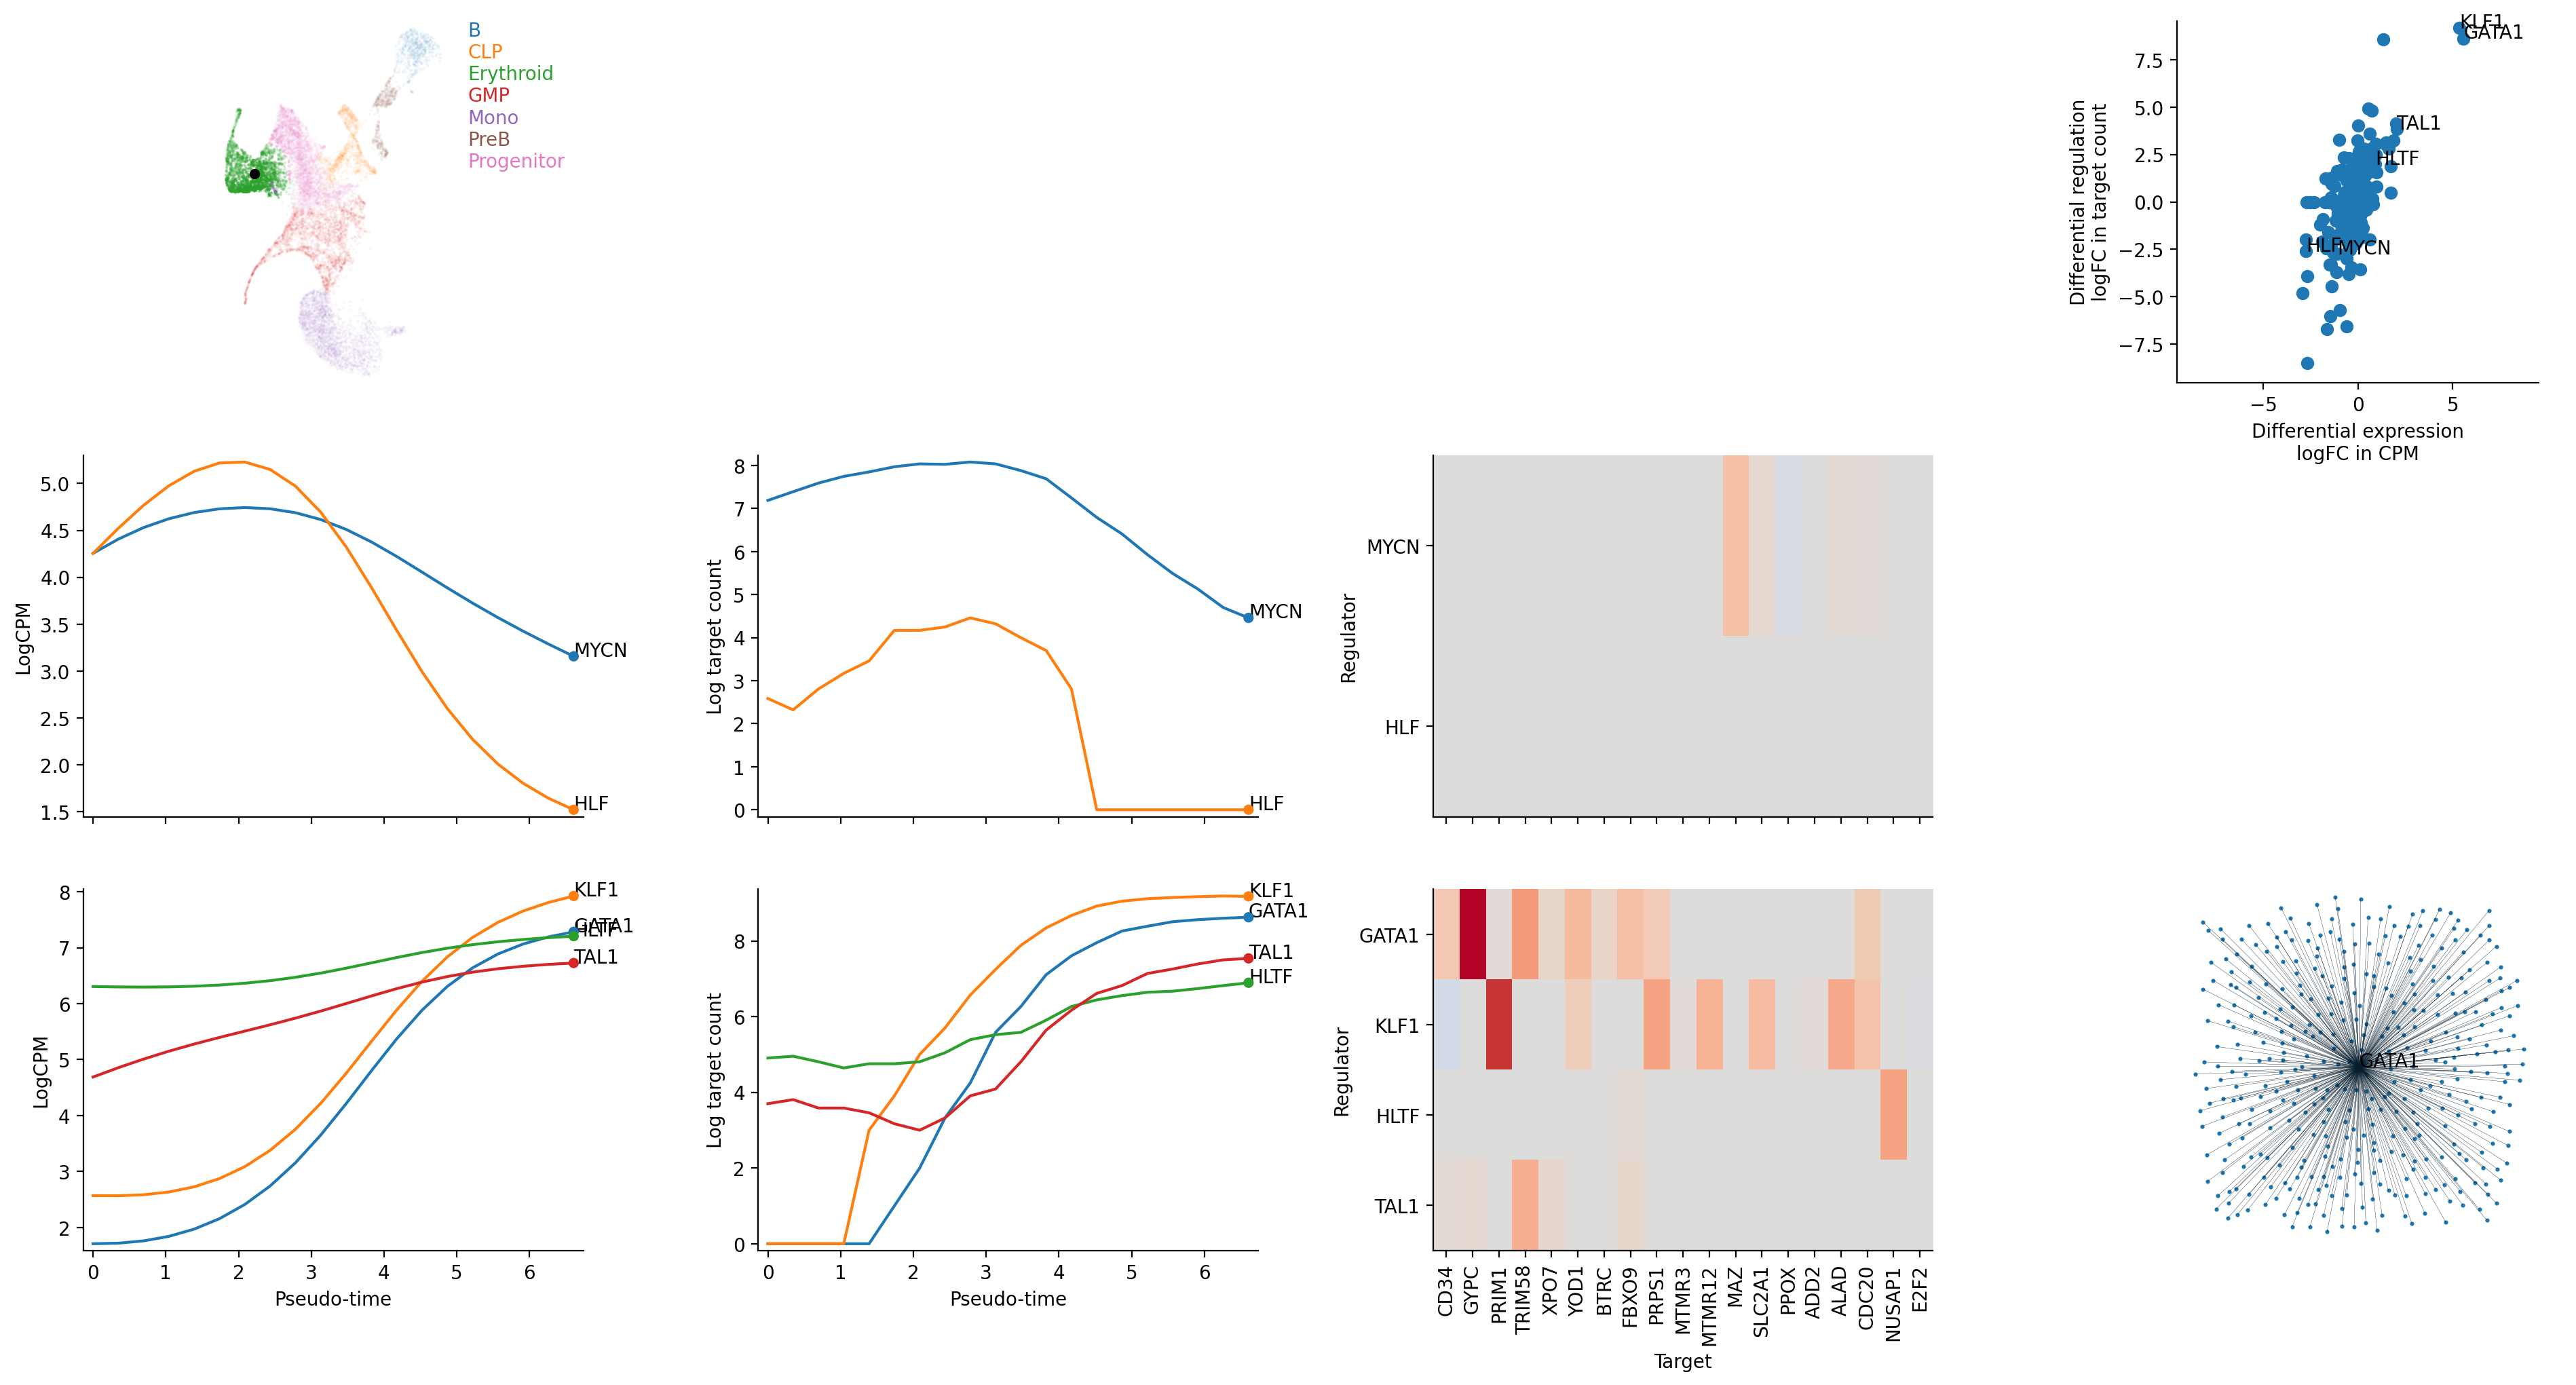

In [7]:
branch=branches[branchname]
n=len(tfs_ann)
assert len(tfs_subnet)==n
# Number of panels per row/column
panelcount=(4,1+n)

########################################
# Prepare dynamic network properties
########################################

# Kernel smoothed network properties
pts,fsmooth=d0.linspace(branch[0],branch[1],nframe,dist)
# Expression, quantified with logCPM
stat1_lcpm=fsmooth(stat.lcpm(d0,cut=0))
# Kernel smoothed network
stat1_net=fsmooth(stat.net(d0))
# Binarized network
stat1_netbin=stat.fbinarize(stat1_net)
# You can change network sparsity (proportion of positive edges) with:
# stat1_netbin=stat.fbinarize(stat1_net,sparsity=0.001)
# Regulatory activity, quantified with log target count
stat1_lntarget=stat.flnneighbor(stat1_netbin)
# Pseudo time
stat1_pseudotime=stat.pseudotime(d0,pts)

# Kernel smoothed network properties for each row or panel
tf_ann=list(set(itertools.chain.from_iterable(tfs_ann)))
# Selecting TF's outgoing edges as subnetwork
stat1_subnets=[stat1_net[x] for x in tfs_subnet]
stat1_subnetbins=[stat1_netbin[x] for x in tfs_subnet]
stat1_subnet_truncs=[stat.function(lambda *y:y[0]*y[1],x,names=x[0].names) for x in zip(stat1_subnets,stat1_subnetbins)]
# Performing layout with linear smoothing of node locations
stat1_layouts=[stat.fsmooth(stat.flayout_base(x,partial(_fruchterman_reingold,stop=20,iterations=50),pts=pts),pts,weightfunc_linear) for x in stat1_subnet_truncs]

########################################
# Draw animation
########################################

# Animation formating
fig=plt.figure(figsize=(panelsize[0]*panelcount[0],panelsize[1]*panelcount[1]),dpi=dpi)
axes=[fig.add_subplot(*panelcount[::-1],x+1) for x in range(panelcount[0]*panelcount[1])]
for ax in axes[:3]:
	[x.set_visible(False) for x in ax.spines.values()]
	ax.set_xticks([])
	ax.set_yticks([])
for ax in axes[3:]:
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.35,hspace=0.2)
def post_init(_):
	# Animation formating function after init
	for xi in itertools.product(range(1,n),range(3)):
		ax=axes[4*xi[0]+xi[1]]
		ax.set_xlabel('')
		ax.xaxis.set_major_formatter('')
	for xi in range(1,n+1):
		axes[4*xi].set_ylabel('LogCPM')
		axes[4*xi+1].set_ylabel('Log target count')
	return []

# Draw each panel with iterator
panels=[]
axes_iter=iter(axes)
# Panel a
panels.append(panel.cellscatter(next(axes_iter),d0,pts,fsmooth))
# Create two empty panels to skip
next(axes_iter)
next(axes_iter)
# Panel b
panels.append(panel.statscatter(next(axes_iter),pts,stat.fdiff(stat1_lcpm,stat.finitial(stat1_lcpm,pts),label=f'Differential expression{linesep}logFC in CPM'),stat.fdiff(stat1_lntarget,stat.finitial(stat1_lntarget,pts),label=f'Differential regulation{linesep}logFC in target count'),annotate=tf_ann,aspect=1,lim={'sym','min','max'}))
# Each row
for xi in range(n):
	# Panel c
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lcpm,names=tfs_ann[xi]))
	# Panel d
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lntarget,names=tfs_ann[xi]))
	# Panel e
	panels.append(panel.statheatmap(next(axes_iter),pts,stat1_net,names=[tfs_ann[xi],target_ann],lim=[-0.3,0.3],cmap='coolwarm',aspect='auto'))
	# Panel f
	panels.append(panel.network(next(axes_iter),pts,stat1_layouts[xi],stat1_subnet_truncs[xi],nodeka={'annotate':tfs_subnet[xi],'scatterka':{'s':5,'lw':0}},edgeka={'lw':0.05}))

# Run animation drawing
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(post_init=post_init)

########################################
# Saving animation
########################################

# Option 1: Visualize animation within jupyter. This will make the notebook large especially with many frames
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,bitrate=bitrate*len(axes)*fps*dpi**2,codec='mpeg4')
w.frame_format='jpeg'
anim.save(f'../../output/animation-{branchname}.mp4',writer=w,dpi='figure')


### Monocyte branch
#### Branch dependent customizations

In [8]:
branchname='Monocyte'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['MYCN'],
	['CEBPB'],
	['USF1'],
]
# Select TFs for each row's other plots
tfs_ann=[
	['HLF','MYCN'],
	['CEBPA','CEBPB','CEBPD','CEBPE','IRF8','KLF4'],
	['FOXO1', 'MAFB', 'USF1', 'JDP2'],
]
# Select genes to annotate as targets in all rows
target_ann=['MYB', 'SOX4', 'ATF3','CD34','IRF8','KLF4','HLA-DRA','CEBPA','CCR2','CSF1R','ITGAM','CTSS','CD14','TIMP2','LGALS2','FCGR3A','CD99','CTSK']


#### Branch independent lines

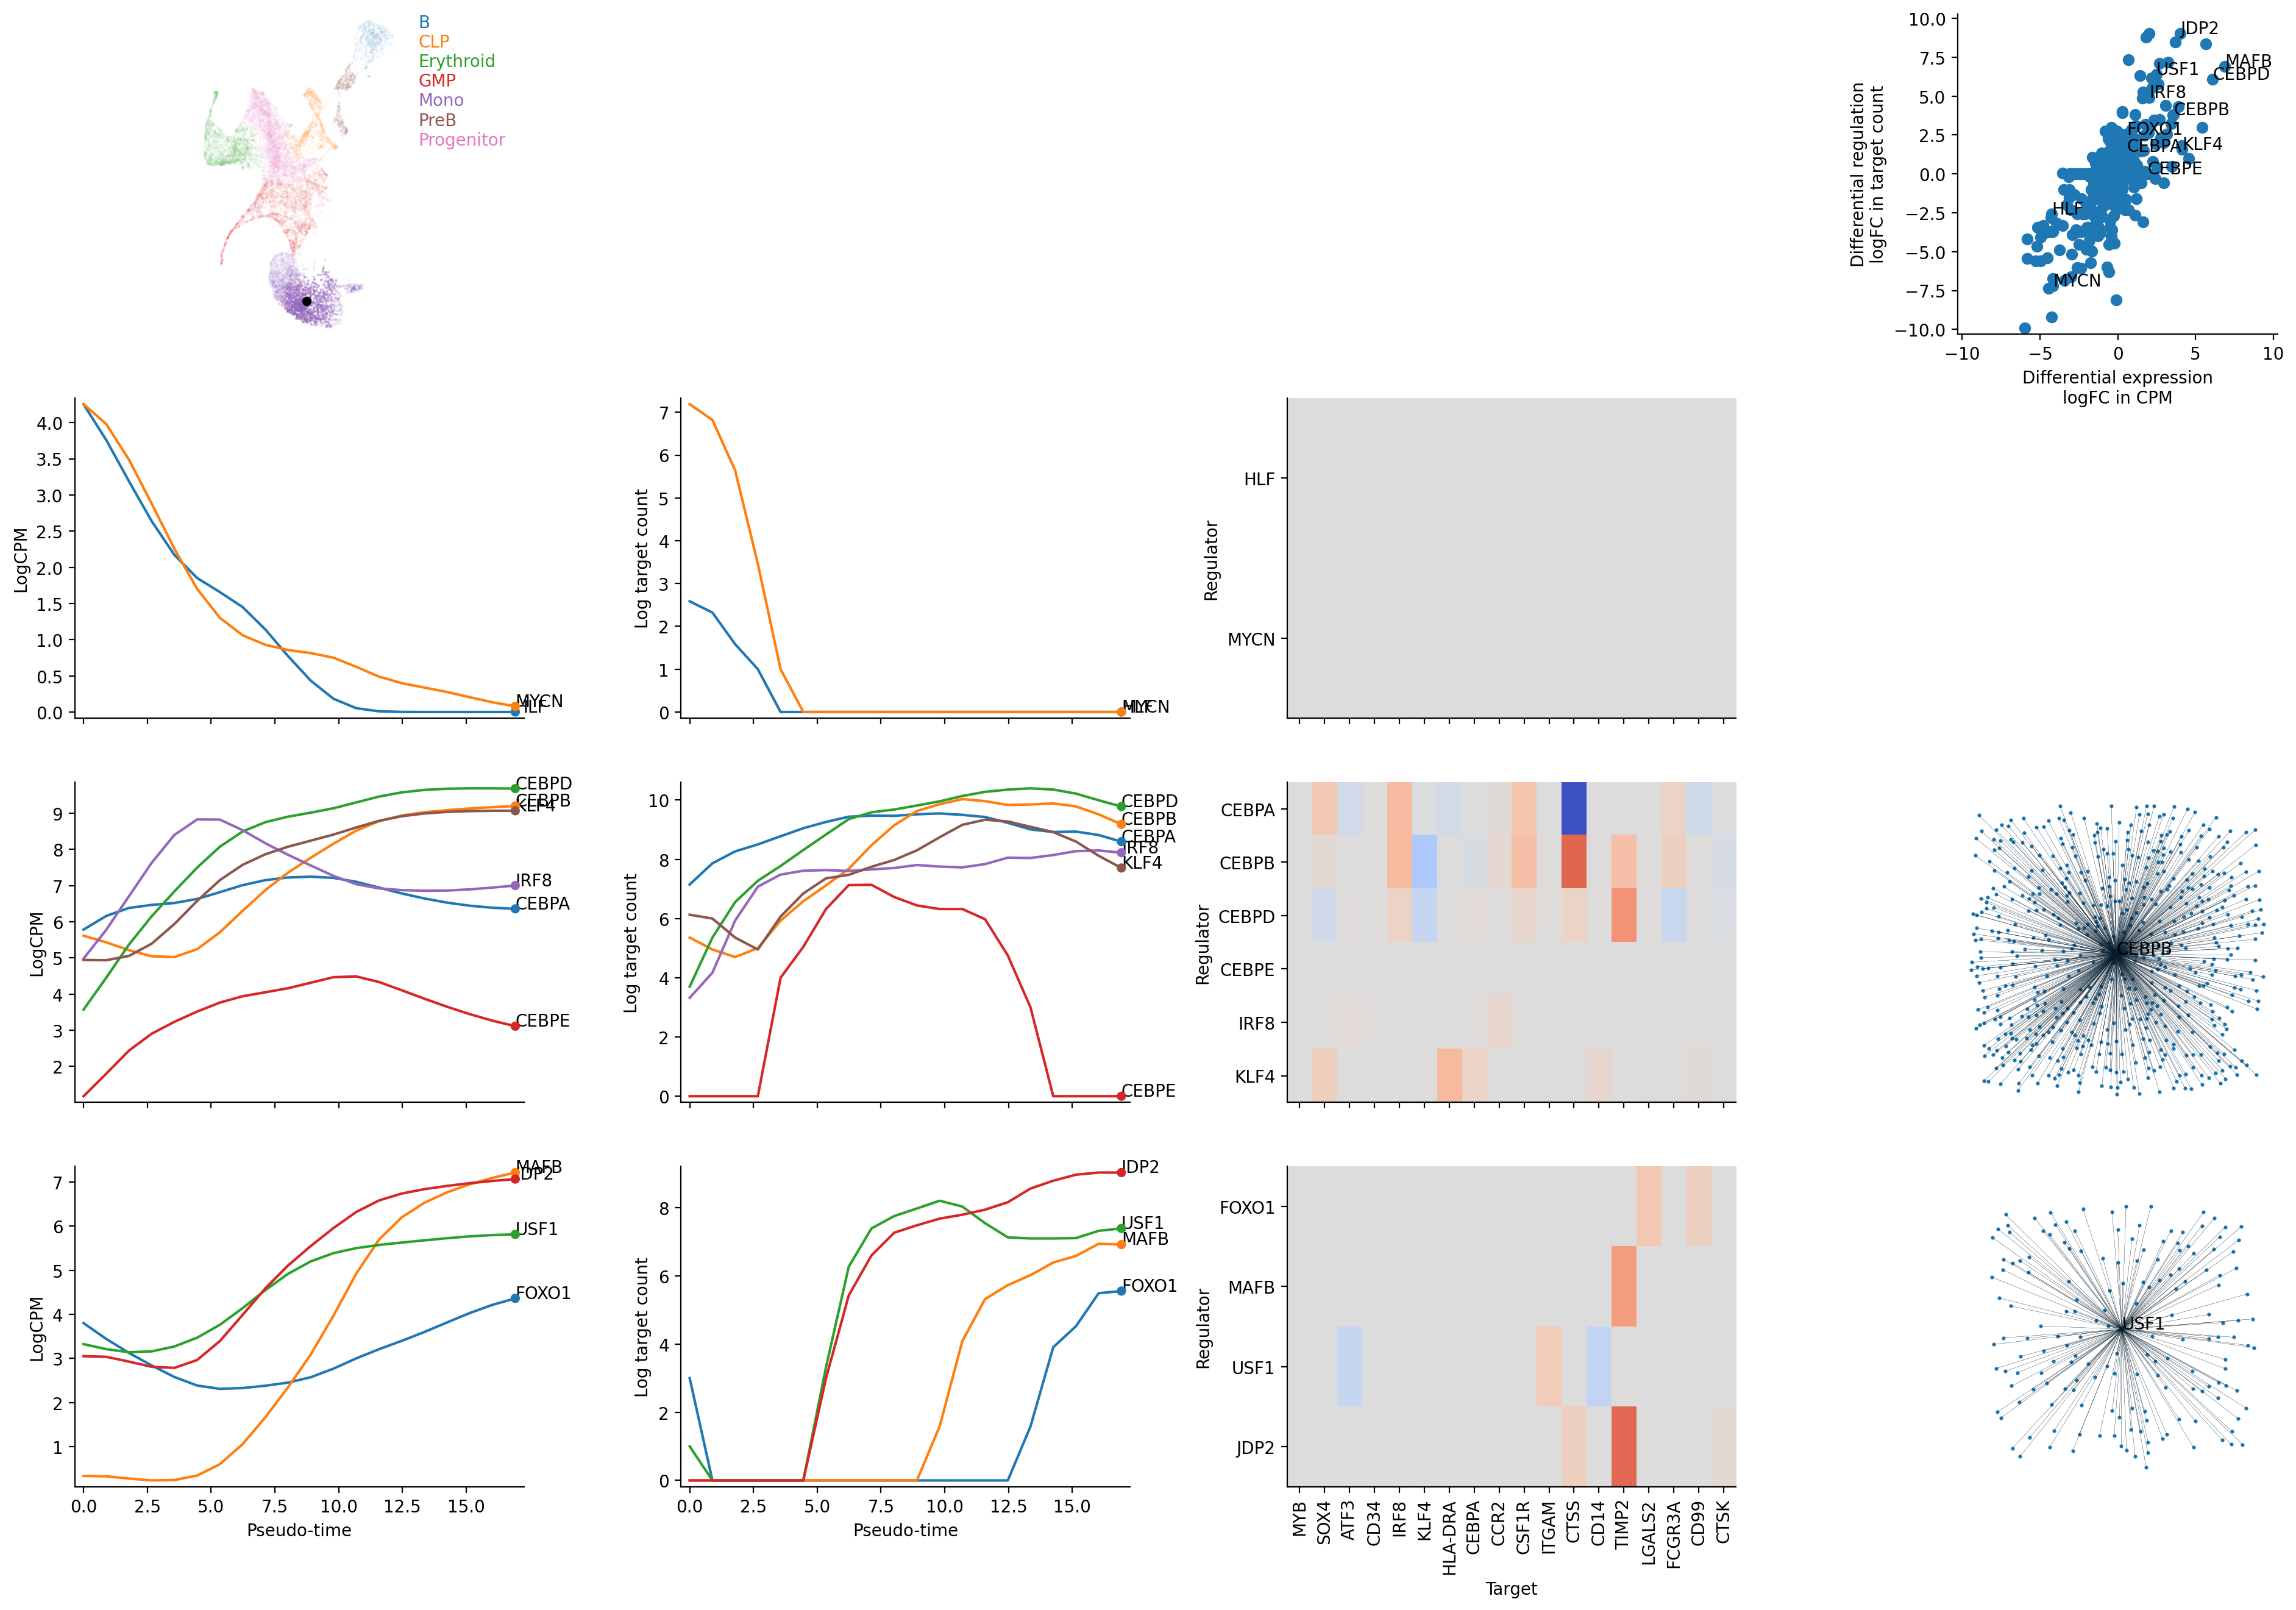

In [9]:
branch=branches[branchname]
n=len(tfs_ann)
assert len(tfs_subnet)==n
# Number of panels per row/column
panelcount=(4,1+n)

########################################
# Prepare dynamic network properties
########################################

# Kernel smoothed network properties
pts,fsmooth=d0.linspace(branch[0],branch[1],nframe,dist)
# Expression: logCPM
stat1_lcpm=fsmooth(stat.lcpm(d0,cut=0))
# Kernel smoothed network
stat1_net=fsmooth(stat.net(d0))
# Binarized network
stat1_netbin=stat.fbinarize(stat1_net)
# You can change network sparsity with: stat1_netbin=stat.fbinarize(stat1_net,sparsity=0.001)
# Regulatory activity: log target count
stat1_lntarget=stat.flnneighbor(stat1_netbin)
# Pseudo time
stat1_pseudotime=stat.pseudotime(d0,pts)

# Kernel smoothed network properties for each row or panel
tf_ann=list(set(itertools.chain.from_iterable(tfs_ann)))
# Selecting TF's outgoing edges as subnetwork
stat1_subnets=[stat1_net[x] for x in tfs_subnet]
stat1_subnetbins=[stat1_netbin[x] for x in tfs_subnet]
stat1_subnet_truncs=[stat.function(lambda *y:y[0]*y[1],x,names=x[0].names) for x in zip(stat1_subnets,stat1_subnetbins)]
# Performing layout with linear smoothing of node locations
stat1_layouts=[stat.fsmooth(stat.flayout_base(x,partial(_fruchterman_reingold,stop=20,iterations=50),pts=pts),pts,weightfunc_linear) for x in stat1_subnet_truncs]

########################################
# Draw animation
########################################

# Animation formating
fig=plt.figure(figsize=(panelsize[0]*panelcount[0],panelsize[1]*panelcount[1]),dpi=dpi)
axes=[fig.add_subplot(*panelcount[::-1],x+1) for x in range(panelcount[0]*panelcount[1])]
for ax in axes[:3]:
	[x.set_visible(False) for x in ax.spines.values()]
	ax.set_xticks([])
	ax.set_yticks([])
for ax in axes[3:]:
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.35,hspace=0.2)
def post_init(_):
	# Animation formating function after init
	for xi in itertools.product(range(1,n),range(3)):
		ax=axes[4*xi[0]+xi[1]]
		ax.set_xlabel('')
		ax.xaxis.set_major_formatter('')
	for xi in range(1,n+1):
		axes[4*xi].set_ylabel('LogCPM')
		axes[4*xi+1].set_ylabel('Log target count')
	return []

# Draw each panel with iterator
panels=[]
axes_iter=iter(axes)
# Panel a
panels.append(panel.cellscatter(next(axes_iter),d0,pts,fsmooth))
# Create two empty panels to skip
next(axes_iter)
next(axes_iter)
# Panel b
panels.append(panel.statscatter(next(axes_iter),pts,stat.fdiff(stat1_lcpm,stat.finitial(stat1_lcpm,pts),label=f'Differential expression{linesep}logFC in CPM'),stat.fdiff(stat1_lntarget,stat.finitial(stat1_lntarget,pts),label=f'Differential regulation{linesep}logFC in target count'),annotate=tf_ann,aspect=1,lim={'sym','min','max'}))
# Each row
for xi in range(n):
	# Panel c
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lcpm,names=tfs_ann[xi]))
	# Panel d
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lntarget,names=tfs_ann[xi]))
	# Panel e
	panels.append(panel.statheatmap(next(axes_iter),pts,stat1_net,names=[tfs_ann[xi],target_ann],lim=[-0.3,0.3],cmap='coolwarm',aspect='auto'))
	# Panel f
	panels.append(panel.network(next(axes_iter),pts,stat1_layouts[xi],stat1_subnet_truncs[xi],nodeka={'annotate':tfs_subnet[xi],'scatterka':{'s':5,'lw':0}},edgeka={'lw':0.05}))

# Run animation drawing
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(post_init=post_init)

########################################
# Saving animation
########################################

# Option 1: Visualize animation within jupyter. This will make the notebook large especially with many frames
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,bitrate=bitrate*len(axes)*fps*dpi**2,codec='mpeg4')
w.frame_format='jpeg'
anim.save(f'../../output/animation-{branchname}.mp4',writer=w,dpi='figure')


### B cell branch
#### Branch dependent customizations

In [10]:
branchname='B'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['MYCN'],
	['IKZF1'],
	['FOXM1'],
	['PAX5'],
]
# Select TFs for each row's other plots
tfs_ann=[
	['MYCN','HLF'],
	['IKZF1','TCF3','FOXO1'],
	['E2F2','FOXM1'],
	['EBF1','SPIB','IRF4','BACH2','PAX5','NFKB2','RELB'],
]
# Select genes to annotate as targets in all rows
target_ann=['ATF3','SOX4','MYB','CD34','RAG1','RAG2','E2F2','CCNB2','CCND3','MME','PIK3CA','MYO1C','PRKCB','SYK', 'SPIB', 'PAX5', 'CD79B']


#### Branch independent lines

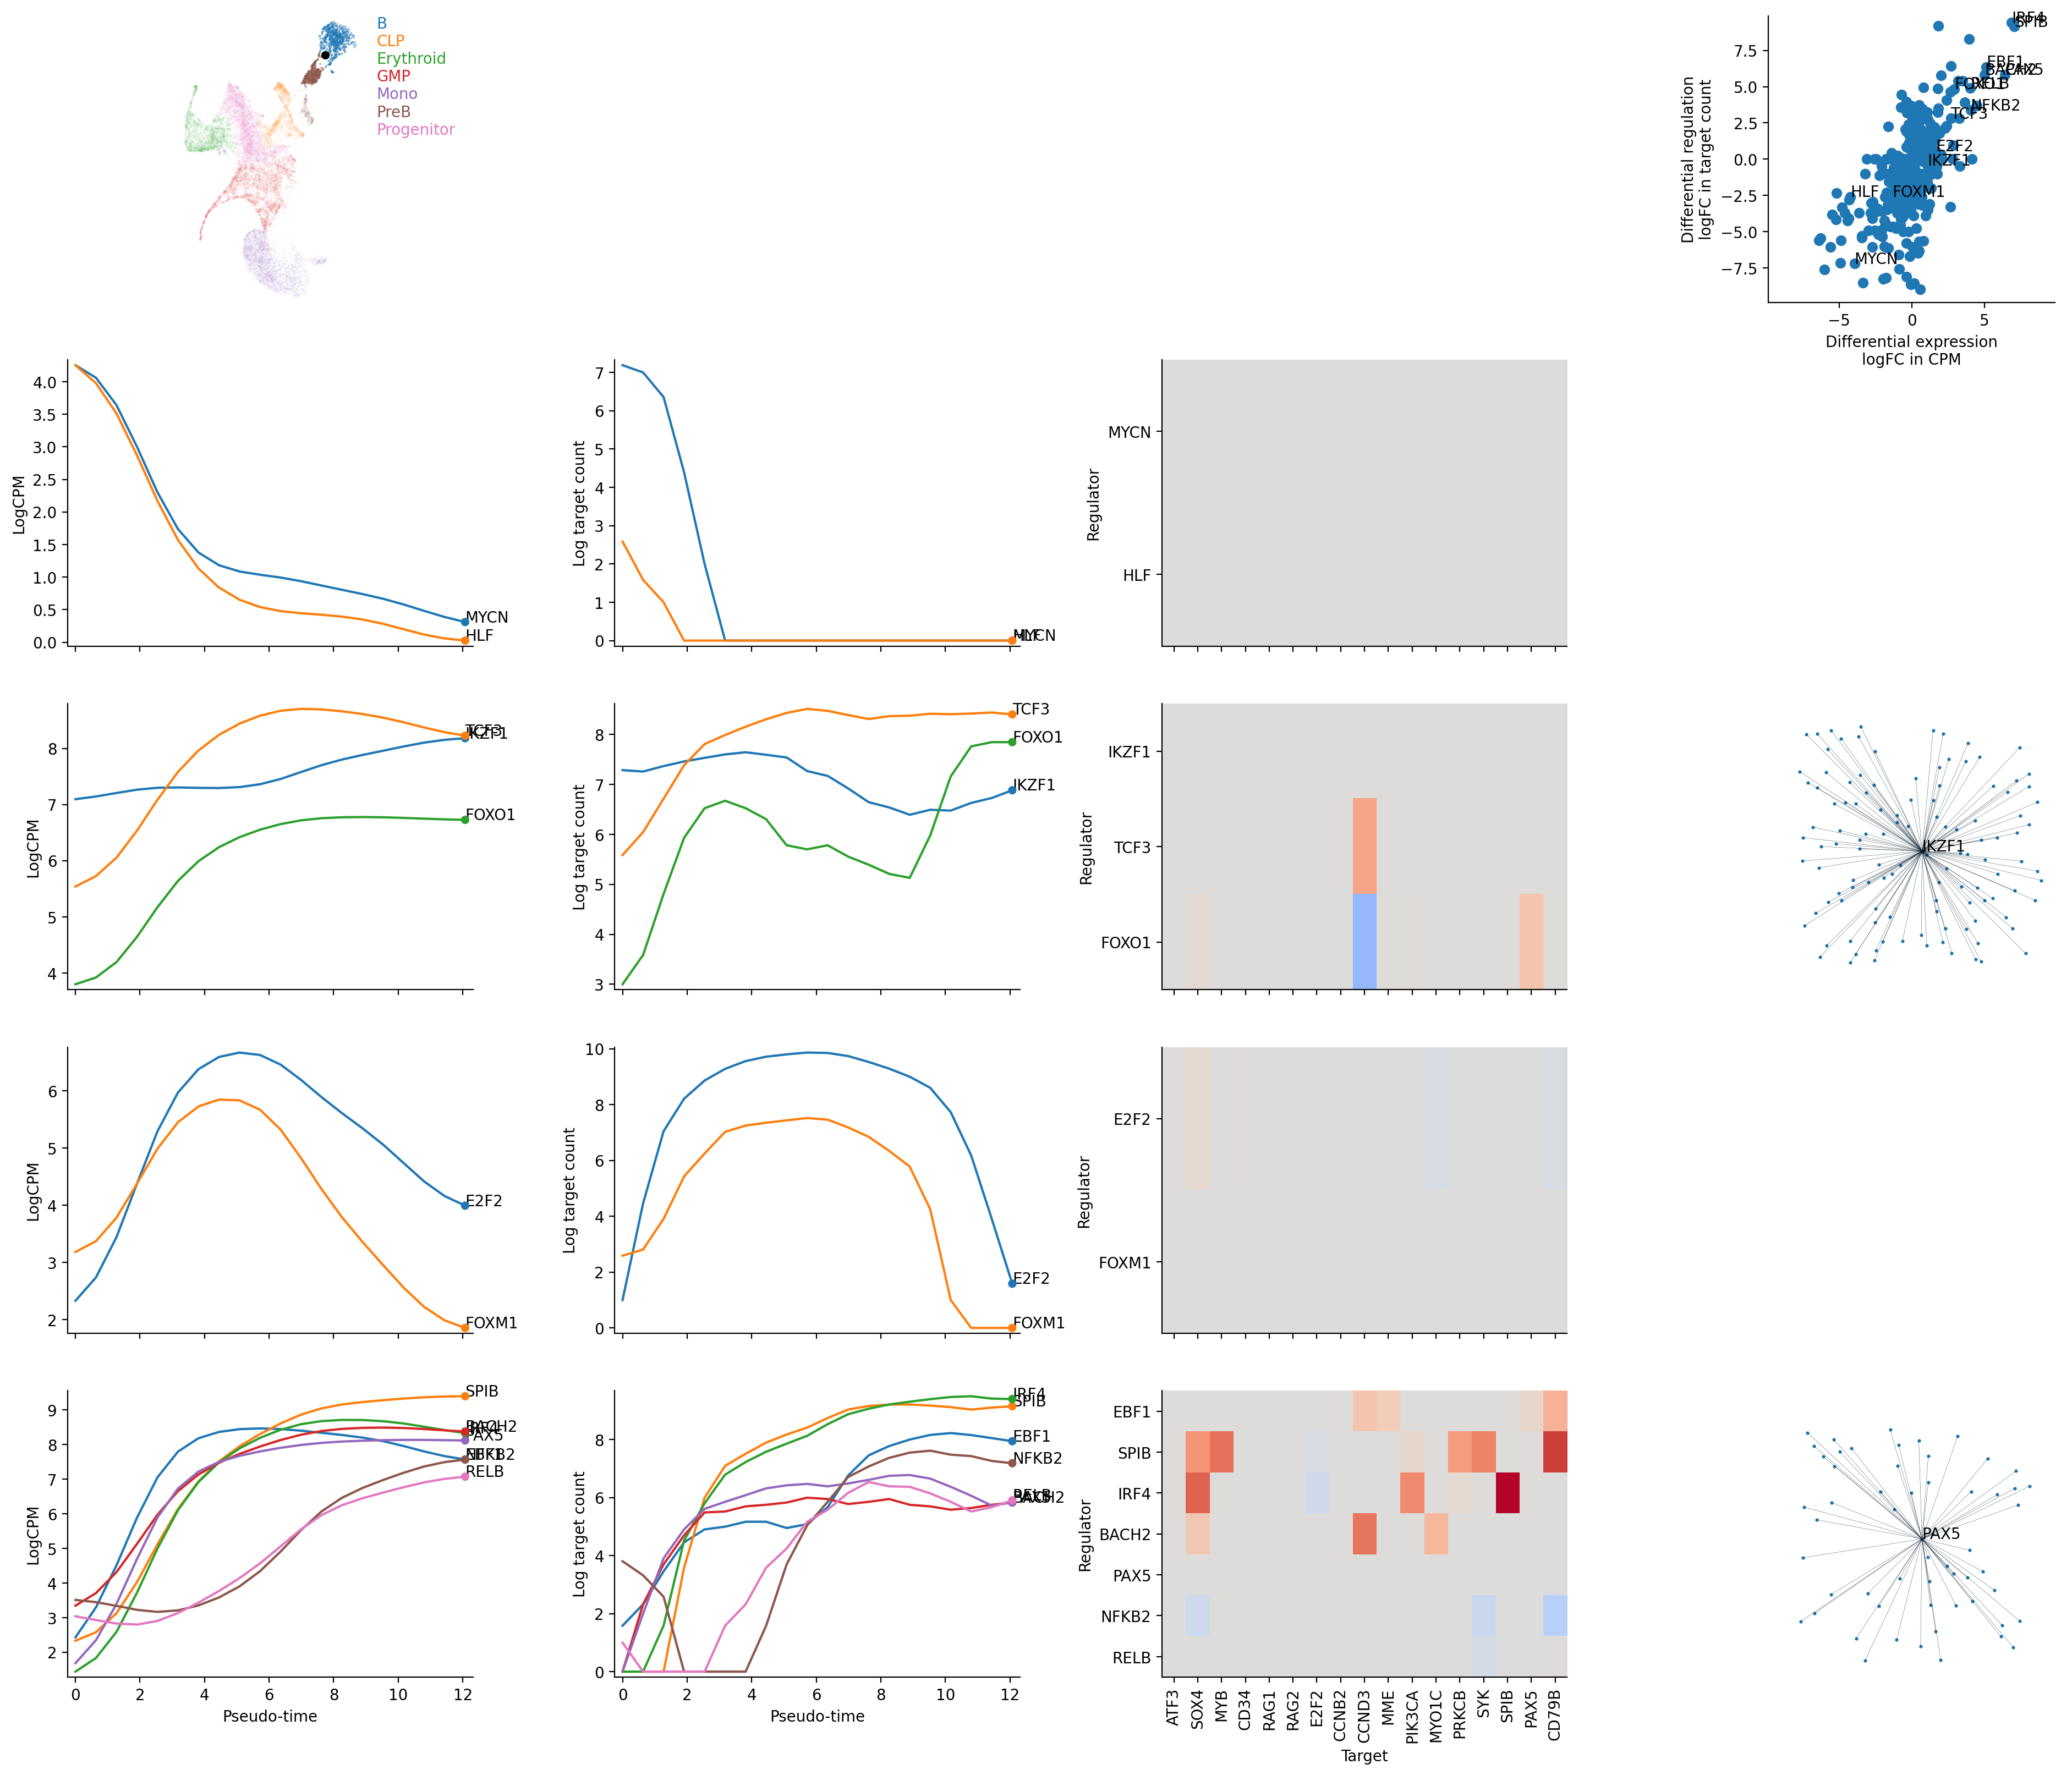

In [11]:
branch=branches[branchname]
n=len(tfs_ann)
assert len(tfs_subnet)==n
# Number of panels per row/column
panelcount=(4,1+n)

########################################
# Prepare dynamic network properties
########################################

# Kernel smoothed network properties
pts,fsmooth=d0.linspace(branch[0],branch[1],nframe,dist)
# Expression: logCPM
stat1_lcpm=fsmooth(stat.lcpm(d0,cut=0))
# Kernel smoothed network
stat1_net=fsmooth(stat.net(d0))
# Binarized network
stat1_netbin=stat.fbinarize(stat1_net)
# You can change network sparsity with: stat1_netbin=stat.fbinarize(stat1_net,sparsity=0.001)
# Regulatory activity: log target count
stat1_lntarget=stat.flnneighbor(stat1_netbin)
# Pseudo time
stat1_pseudotime=stat.pseudotime(d0,pts)

# Kernel smoothed network properties for each row or panel
tf_ann=list(set(itertools.chain.from_iterable(tfs_ann)))
# Selecting TF's outgoing edges as subnetwork
stat1_subnets=[stat1_net[x] for x in tfs_subnet]
stat1_subnetbins=[stat1_netbin[x] for x in tfs_subnet]
stat1_subnet_truncs=[stat.function(lambda *y:y[0]*y[1],x,names=x[0].names) for x in zip(stat1_subnets,stat1_subnetbins)]
# Performing layout with linear smoothing of node locations
stat1_layouts=[stat.fsmooth(stat.flayout_base(x,partial(_fruchterman_reingold,stop=20,iterations=50),pts=pts),pts,weightfunc_linear) for x in stat1_subnet_truncs]

########################################
# Draw animation
########################################

# Animation formating
fig=plt.figure(figsize=(panelsize[0]*panelcount[0],panelsize[1]*panelcount[1]),dpi=dpi)
axes=[fig.add_subplot(*panelcount[::-1],x+1) for x in range(panelcount[0]*panelcount[1])]
for ax in axes[:3]:
	[x.set_visible(False) for x in ax.spines.values()]
	ax.set_xticks([])
	ax.set_yticks([])
for ax in axes[3:]:
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.35,hspace=0.2)
def post_init(_):
	# Animation formating function after init
	for xi in itertools.product(range(1,n),range(3)):
		ax=axes[4*xi[0]+xi[1]]
		ax.set_xlabel('')
		ax.xaxis.set_major_formatter('')
	for xi in range(1,n+1):
		axes[4*xi].set_ylabel('LogCPM')
		axes[4*xi+1].set_ylabel('Log target count')
	return []

# Draw each panel with iterator
panels=[]
axes_iter=iter(axes)
# Panel a
panels.append(panel.cellscatter(next(axes_iter),d0,pts,fsmooth))
# Create two empty panels to skip
next(axes_iter)
next(axes_iter)
# Panel b
panels.append(panel.statscatter(next(axes_iter),pts,stat.fdiff(stat1_lcpm,stat.finitial(stat1_lcpm,pts),label=f'Differential expression{linesep}logFC in CPM'),stat.fdiff(stat1_lntarget,stat.finitial(stat1_lntarget,pts),label=f'Differential regulation{linesep}logFC in target count'),annotate=tf_ann,aspect=1,lim={'sym','min','max'}))
# Each row
for xi in range(n):
	# Panel c
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lcpm,names=tfs_ann[xi]))
	# Panel d
	panels.append(panel.statplot(next(axes_iter),pts,stat1_pseudotime,stat1_lntarget,names=tfs_ann[xi]))
	# Panel e
	panels.append(panel.statheatmap(next(axes_iter),pts,stat1_net,names=[tfs_ann[xi],target_ann],lim=[-0.3,0.3],cmap='coolwarm',aspect='auto'))
	# Panel f
	panels.append(panel.network(next(axes_iter),pts,stat1_layouts[xi],stat1_subnet_truncs[xi],nodeka={'annotate':tfs_subnet[xi],'scatterka':{'s':5,'lw':0}},edgeka={'lw':0.05}))

# Run animation drawing
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(post_init=post_init)

########################################
# Saving animation
########################################

# Option 1: Visualize animation within jupyter. This will make the notebook large especially with many frames
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,bitrate=bitrate*len(axes)*fps*dpi**2,codec='mpeg4')
w.frame_format='jpeg'
anim.save(f'../../output/animation-{branchname}.mp4',writer=w,dpi='figure')


## Export dynamic network to folder

In [12]:
branchname='Erythroid'
output_folder=f'../../output/export/{branchname}'

#Start/stop node ID on trajectory
start_node,stop_node=branches[branchname]
#Number of timepoints to export
n_timepoint=10
#Gaussian kernel smoothing distance
dist_smooth=1.5
#Choose which sparsities (proportion of positive edges) to export network
#Use None to export continuous network
sparsities=[None,0.01]

d0.export(output_folder,start_node,stop_node,n_timepoint,dist_smooth,sparsities=sparsities)
